# 2. Clustering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
df_in = pd.read_parquet('data/ml_dataset_preprocessed.parquet')

The expert has generated four different labels. In order to test that this is reasonable, and also in order to evaluate the labeling of the expert, I will use clustering to study what number of states would be appropriate.

In the clustering, I use the Fourier Transformed voltage and current data. In addition, I will use the sensor_0 data as it seems to be correlated with the states. I will not use sensor_1 ... sensor_5 as they don't seem to include much relevant information for our purpose.

I will perform the cluster on both the full dataset, and on the labeled dataset only.

## The full dataset

The full dataset consists of both labeled and unlabeled data. Some data points have been dropped as they contained empty values. See the preprocessing document for more details.

In [3]:
df_clustering_full = df_in.iloc[:, 2:6]

In [4]:
df_clustering_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51577 entries, 0 to 51576
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   voltage_freq_100  51577 non-null  float64
 1   current_freq_50   51577 non-null  float64
 2   current_freq_100  51577 non-null  float64
 3   sensor_0          51577 non-null  float64
dtypes: float64(4)
memory usage: 1.6 MB


I standardize the data as the sensor data is on a different scale from the voltage and current data.

In [5]:
sc = StandardScaler()
df_clustering_full_scaled = pd.DataFrame(sc.fit_transform(df_clustering_full), columns=df_clustering_full.columns)

### K-Means Clustering

My primary choice of clustering method is K-Means Clustering. To determine the appropriate number of clusters, the "elbow method" will be used. The elbow method is described in detail in [this Wikipedia article](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). WCSS below stands for "within-clusters sum of squares".

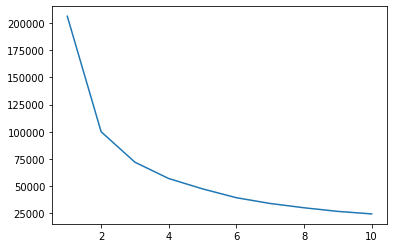

In [6]:
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clustering_full_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), wcss)
plt.show()

Based on the elbow method, using four labels does not seem justifiable. The "elbow" is at two clusters. It could also be argued that three clusters can be used, but four clusters does not seem sensible.

### Hierarchical clustering

In this exercise, I will only use hierarchical clustering to validate (or invalidate) our K-Means Clustering findings. I will inspect the dendrogram of the hierarchical clustering, and use Euclidean distances to determine what the appropriate amount of clusters should be. I will use the Ward variance minimization algorithm. For more information, see [SciPy's documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

Running this with the full dataset takes some time.

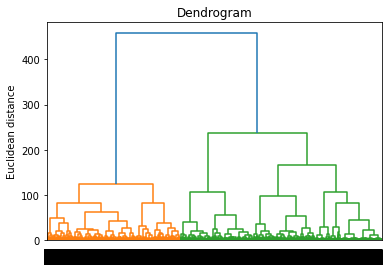

In [7]:
dendrogram = sch.dendrogram(sch.linkage(df_clustering_full_scaled, method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

The dendrogram partially validates my K-Means Clustering findings. The optimal number of clusters is probably two, but could be three. However, it is probably not four.

## The labeled dataset

I repeat the exercise above with using labeled data only.

### K-Means Clustering

In [8]:
df_clustering_labeled = df_in.dropna().iloc[:, 2:6]

In [9]:
df_clustering_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5151 entries, 9 to 51574
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   voltage_freq_100  5151 non-null   float64
 1   current_freq_50   5151 non-null   float64
 2   current_freq_100  5151 non-null   float64
 3   sensor_0          5151 non-null   float64
dtypes: float64(4)
memory usage: 201.2 KB


In [10]:
sc = StandardScaler()
df_clustering_labeled_scaled = pd.DataFrame(sc.fit_transform(df_clustering_labeled), columns=df_clustering_labeled.columns)

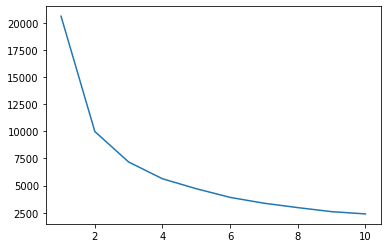

In [11]:
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clustering_labeled_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), wcss)
plt.show()

Using the more limited dataset does not change my conclusion.

### Hierarchical clustering

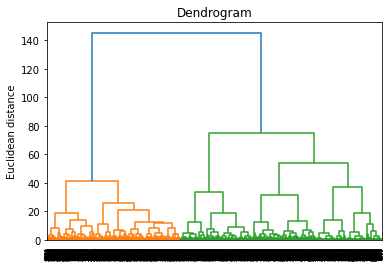

In [12]:
dendrogram = sch.dendrogram(sch.linkage(df_clustering_labeled_scaled, method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

Again, the dendrogram validates my previous findings.

## Evaluating the expert labels

As identified previously, the number of lables we have is four while the optimal number seems to be two, or potentially three. I therefore need to investigate how to combine the expert clusters, and evaluate how well the expert has identified anomalies (i.e. non-label 1).

In [13]:
df_labeled = df_in.dropna().reset_index(drop=True)

### Using two clusters

We start with using two clusters. I perform the clustering and then print the confusion matrix. Since K-Means clusters start from 0, I add 1 to the K-Means cluster in the confusion matrix to make the results more representable.

In [14]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(df_labeled.iloc[:, 2:6])

df_labeled['label'] = df_labeled['label'].astype('int32')
df_labeled['label_kmeans'] = kmeans_labels

In [15]:
print(confusion_matrix(df_labeled.label_kmeans + 1, df_labeled.label))

[[ 790    0 1055    0]
 [1239 1004    7 1056]
 [   0    0    0    0]
 [   0    0    0    0]]


On the horizontal level, we have the expert labels. Label 1 is the first column, label 2 the second, etc. On the vertical level, we have the two K-Means clusters.

If we were to use two clusters, the expert labels 1, 2 and 4 should be merged. That would leave us with only one anomaly: label 3.

The results also indicate that the expert could have made a pretty poor job in identifying the expected state, i.e. label 1. If we assume that label 3 is the only anomaly, approximately 39% of the expected states have been incorrectly classified.

If we, however, would decide that labels 1 and 3 are the expected state, and 2 and 4 are the anomalies, 61% of the expected states would have been incorrectly classified.

Given such a high level of potentially incorrect classifications, it would be good to investigate the clustering further. Such an investigation will not be performed here, however, so not to use too much time on this exercise.

### Using three clusters

I then move on to using three clusters.

In [16]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(df_labeled.iloc[:, 2:6])

df_labeled['label'] = df_labeled['label'].astype('int32')
df_labeled['label_kmeans'] = kmeans_labels

In [17]:
print(confusion_matrix(df_labeled.label_kmeans + 1, df_labeled.label))

[[1975   79   39  132]
 [   8  925    0  924]
 [  46    0 1023    0]
 [   0    0    0    0]]


In this case, the expert labels are again on the horizontal axis, while the K-Means clusters are on rows 1, 2 and 3 respectively.

When inspecting the three-cluster confusion matrix, it seems to be more sensible to use three clusters rather than two, unless we think that the expert is not very good at his job. The three-cluster results suggest that labels 2 and 4 could be combined, and that we would end up with labels 1 (expected state), 3 and 2+4.

In such a case, the error rate of the expert is much lower.

### Using four clusters

Using four clusters allows us to most clearly evaluate the performance of the expert. We will see if the K-Means algorithm agrees with the expert's discretion.

In [18]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(df_labeled.iloc[:, 2:6])

df_labeled['label'] = df_labeled['label'].astype('int32')
df_labeled['label_kmeans'] = kmeans_labels

In [19]:
print(confusion_matrix(df_labeled.label_kmeans + 1, df_labeled.label))

[[ 947    0   39    0]
 [   1  799    0  840]
 [  11    0 1023    0]
 [1070  205    0  216]]


The expert's tabels are again on the horizontal axis, and the algorithm's labels on the vertical axis.

We see that while many of the observations fall on the diagonal of the confusion matrix (which would indicate that the clustering algorithm and expert agrees), there are also many observations that don't fall on the horizontal axis.

More precisely 2985 observations out of 5151, or approximately 58% are on the diagonal. This in turns indicates that 42% of the observations have been misclassified.

Again, given the fairly large error, this would justify a more thorough examination of the clusters. In an attempt to keep this brief, I will not carry out such an exercise here.

### Bonus: Using five clusters

In [20]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(df_labeled.iloc[:, 2:6])

df_labeled['label'] = df_labeled['label'].astype('int32')
df_labeled['label_kmeans'] = kmeans_labels

In [21]:
print(confusion_matrix(df_labeled.label_kmeans + 1, df_labeled.label))

[[  26  627    0  484    0]
 [  11    0 1023    0    0]
 [ 945    0   39    0    0]
 [1047   69    0   93    0]
 [   0  308    0  479    0]]


Five clusters doesn't seem sensible based on these results, as the first and the last cluster produced by the K-Means algorithm are very similar, and so is the third and fourth.

## Conclusion

Given the analysis above, the most appropriate number of labels seems to be three. It can also be argued that the most optimal number is two.

In either case, this analysis indicates that the expert labels should be investigated more closely.